Please drag and drop the 'data10.csv' file here and press Enter: /content/data10.csv
Loading dataset...
Dataset loaded successfully.


<ipython-input-17-0f31b4d910db>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Sentence #"] = df["Sentence #"].fillna(method="ffill")  # Forward fill sentence numbers






initial_states	 {'O': 0.7128987517337032, 'B-per': 0.09292649098474341, 'B-gpe': 0.08737864077669903, 'B-org': 0.049930651872399444, 'B-geo': 0.047156726768377254, 'B-tim': 0.009246417013407305, 'B-nat': 0.0004623208506703652}
transition_probs	 {'O': {'O': 0.8934765086711214, 'B-geo': 0.03361847065858922, 'B-gpe': 0.01874626244767427, 'B-tim': 0.019396271547801668, 'B-org': 0.020540287564025896, 'B-per': 0.01164816307428304, 'B-nat': 0.00041600582408153717, 'B-art': 0.0011440160162242271, 'B-eve': 0.0010140141961987469}, 'B-geo': {'O': 0.7942857142857143, 'I-geo': 0.1742857142857143, 'B-tim': 0.025714285714285714, 'B-per': 0.0007142857142857143, 'B-gpe': 0.005}, 'B-gpe': {'O': 0.8556034482758621, 'B-per': 0.08512931034482758, 'I-gpe': 0.028017241379310345, 'B-org': 0.03017241379310345, 'B-tim': 0.0010775862068965517}, 'B-tim': {'O': 0.8067632850241546, 'I-tim': 0.1823671497584541, 'B-gpe': 0.0036231884057971015, 'B-per': 0.0012077294685990338, 'B-geo': 0.0036231884057971015, 'B-nat

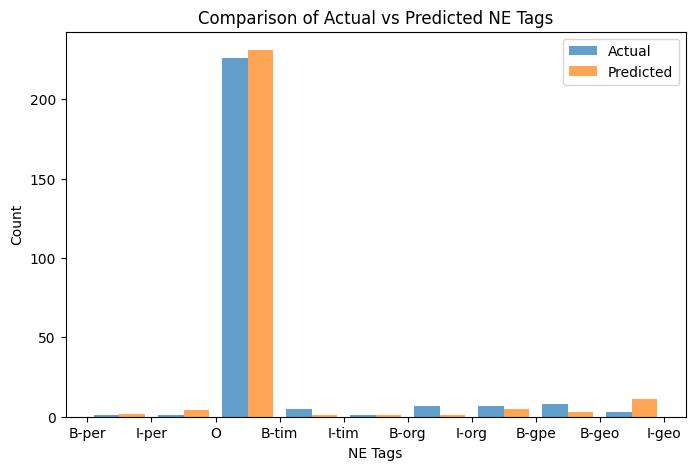

In [17]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# Function to upload and load dataset
def load_data():
    file_path = input("Please drag and drop the 'data10.csv' file here and press Enter: ").strip()
    if not file_path:
        raise ValueError("No file selected. Please upload the correct file.")
    print("Loading dataset...")
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    return df

# Load dataset
df = load_data()
df["Sentence #"] = df["Sentence #"].fillna(method="ffill")  # Forward fill sentence numbers

# Determine training and test split
sentence_starts = df[df["Sentence #"].notna()].index
train_cutoff = sentence_starts[47700] if len(sentence_starts) > 47700 else len(df)
test_start = sentence_starts[-259] if len(sentence_starts) >= 259 else 0

train_data = df.iloc[:train_cutoff]
test_data = df.iloc[test_start:]

# Compute HMM parameters
def compute_hmm_parameters(train_data):
    train_sentences_grouped = train_data.groupby("Sentence #")

    # #1: Initial state probabilities
    # Initial state probabilities Pi are the relative frequency of each NE Tag in the first word of each sentence.
    initial_states = train_sentences_grouped.first()["NE Tag"].value_counts(normalize=True).to_dict()

    # #2: Transition probabilities
    # Transition probabilities A are calculated based on the frequency of tag transitions (from one NE tag to another).
    transition_counts = defaultdict(Counter)
    for _, group in train_sentences_grouped:
        tags = group["NE Tag"].tolist()
        for i in range(len(tags) - 1):
            transition_counts[tags[i]][tags[i + 1]] += 1

    transition_probs = {tag: {next_tag: count / sum(transition_counts[tag].values())
                               for next_tag, count in transition_counts[tag].items()}
                        for tag in transition_counts}

    # #3: Emission probabilities
    # Emission probabilities B are the probabilities of a particular NE tag occurring for a given POS.
    emission_counts = defaultdict(Counter)
    for _, row in train_data.iterrows():
        emission_counts[row["NE Tag"]][row["POS"]] += 1

    emission_probs = {tag: {pos: count / sum(emission_counts[tag].values())
                             for pos, count in emission_counts[tag].items()}
                      for tag in emission_counts}

    return initial_states, transition_probs, emission_probs

# Viterbi algorithm
def viterbi_algorithm(sentence, states, initial_probs, transition_probs, emission_probs):
    n = len(sentence)
    m = len(states)
    viterbi = np.zeros((m, n))  # Probability table
    backpointer = np.zeros((m, n), dtype=int)  # Backtracking table

    # #4: Initialize the Viterbi table
    for i, state in enumerate(states):
        viterbi[i, 0] = initial_probs.get(state, 1e-6) * emission_probs.get(state, {}).get(sentence[0], 1e-6)

    # #5: Recursion step: for each subsequent word in the sentence, compute the maximum probability
    for t in range(1, n):
        for j, state in enumerate(states):
            max_prob, max_state = max(
                (viterbi[i, t-1] * transition_probs.get(prev_state, {}).get(state, 1e-6) *
                 emission_probs.get(state, {}).get(sentence[t], 1e-6), i)
                for i, prev_state in enumerate(states)
            )
            viterbi[j, t] = max_prob
            backpointer[j, t] = max_state

    # #6: Backtrack to find the most probable sequence of states (tags)
    best_path = []
    best_last_state = np.argmax(viterbi[:, -1])
    for t in range(n - 1, -1, -1):
        best_path.append(states[best_last_state])
        best_last_state = backpointer[best_last_state, t]

    return best_path[::-1]

# Evaluate model
def evaluate_model(test_data, initial_states, transition_probs, emission_probs):
    test_sentences_grouped = test_data.groupby("Sentence #")
    states = list(transition_probs.keys())

    predictions, actuals = [], []

    # #7: Evaluate the model on the test data
    for _, group in test_sentences_grouped:
        pos_sequence = group["POS"].tolist()
        true_ne_tags = group["NE Tag"].tolist()
        pred_ne_tags = viterbi_algorithm(pos_sequence, states, initial_states, transition_probs, emission_probs)
        predictions.extend(pred_ne_tags)
        actuals.extend(true_ne_tags)

    # #8: Calculate accuracy
    accuracy = sum(p == a for p, a in zip(predictions, actuals)) / len(actuals)
    return accuracy, predictions, actuals

# Plot results
def plot_results(actuals, predictions):
    plt.figure(figsize=(8, 5))
    plt.hist([actuals, predictions], label=["Actual", "Predicted"], bins=len(set(actuals)), alpha=0.7)
    plt.xlabel("NE Tags")
    plt.ylabel("Count")
    plt.title("Comparison of Actual vs Predicted NE Tags")
    plt.legend()
    plt.show()

# Main execution
if __name__ == "__main__":
    initial_states, transition_probs, emission_probs = compute_hmm_parameters(train_data)
    print('\n')
    print('\n')
    print("initial_states\t",initial_states)
    print("transition_probs\t",transition_probs )
    print("emission_probs\t",emission_probs)

    # #9: Run the evaluation and display the accuracy
    accuracy, predictions, actuals = evaluate_model(test_data, initial_states, transition_probs, emission_probs)
    print(f"Model Accuracy: {accuracy:.2%}")

    # #10: Plot the comparison between actual and predicted NE tags
    plot_results(actuals, predictions)


Please drag and drop the 'data10.csv' file here and press Enter: /content/data10.csv
Loading dataset...
Dataset loaded successfully.


<ipython-input-20-4e0d4eb9f08b>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Sentence #"] = df["Sentence #"].fillna(method="ffill")  # Forward fill sentence numbers



1. Initial State Distribution (Pi):
{'O': 0.7128987517337032, 'B-per': 0.09292649098474341, 'B-gpe': 0.08737864077669903, 'B-org': 0.049930651872399444, 'B-geo': 0.047156726768377254, 'B-tim': 0.009246417013407305, 'B-nat': 0.0004623208506703652}

2. State Transition Probabilities (A):
{'O': {'O': 0.8934765086711214, 'B-geo': 0.03361847065858922, 'B-gpe': 0.01874626244767427, 'B-tim': 0.019396271547801668, 'B-org': 0.020540287564025896, 'B-per': 0.01164816307428304, 'B-nat': 0.00041600582408153717, 'B-art': 0.0011440160162242271, 'B-eve': 0.0010140141961987469}, 'B-geo': {'O': 0.7942857142857143, 'I-geo': 0.1742857142857143, 'B-tim': 0.025714285714285714, 'B-per': 0.0007142857142857143, 'B-gpe': 0.005}, 'B-gpe': {'O': 0.8556034482758621, 'B-per': 0.08512931034482758, 'I-gpe': 0.028017241379310345, 'B-org': 0.03017241379310345, 'B-tim': 0.0010775862068965517}, 'B-tim': {'O': 0.8067632850241546, 'I-tim': 0.1823671497584541, 'B-gpe': 0.0036231884057971015, 'B-per': 0.0012077294685990338,

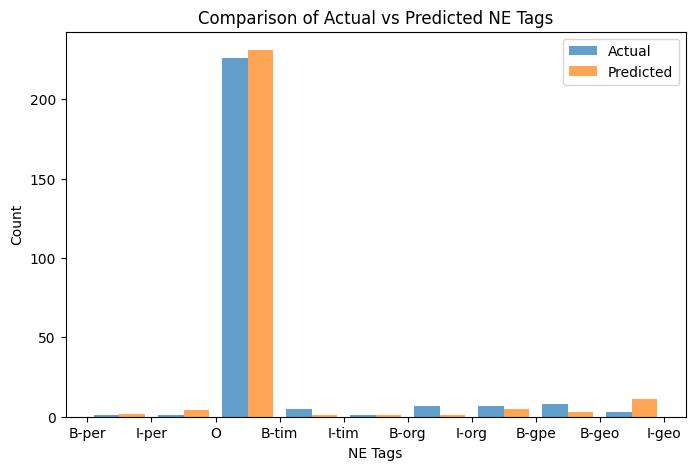

In [20]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# Function to upload and load dataset
def load_data():
    file_path = input("Please drag and drop the 'data10.csv' file here and press Enter: ").strip()
    if not file_path:
        raise ValueError("No file selected. Please upload the correct file.")
    print("Loading dataset...")
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    return df

# Load dataset
df = load_data()
df["Sentence #"] = df["Sentence #"].fillna(method="ffill")  # Forward fill sentence numbers

# Determine training and test split
sentence_starts = df[df["Sentence #"].notna()].index
train_cutoff = sentence_starts[47700] if len(sentence_starts) > 47700 else len(df)
test_start = sentence_starts[-259] if len(sentence_starts) >= 259 else 0

train_data = df.iloc[:train_cutoff]
test_data = df.iloc[test_start:]

# Compute HMM parameters
def compute_hmm_parameters(train_data):
    train_sentences_grouped = train_data.groupby("Sentence #")

    # #1: Initial state probabilities
    initial_states = train_sentences_grouped.first()["NE Tag"].value_counts(normalize=True).to_dict()
    print("\n1. Initial State Distribution (Pi):")
    print(initial_states)

    # #2: Transition probabilities
    transition_counts = defaultdict(Counter)
    for _, group in train_sentences_grouped:
        tags = group["NE Tag"].tolist()
        for i in range(len(tags) - 1):
            transition_counts[tags[i]][tags[i + 1]] += 1

    transition_probs = {tag: {next_tag: count / sum(transition_counts[tag].values())
                               for next_tag, count in transition_counts[tag].items()}
                        for tag in transition_counts}
    print("\n2. State Transition Probabilities (A):")
    print(transition_probs)

    # #3: Emission probabilities
    emission_counts = defaultdict(Counter)
    for _, row in train_data.iterrows():
        emission_counts[row["NE Tag"]][row["POS"]] += 1

    emission_probs = {tag: {pos: count / sum(emission_counts[tag].values())
                             for pos, count in emission_counts[tag].items()}
                      for tag in emission_counts}
    print("\n3. State Observation Probabilities (B):")
    print(emission_probs)

    return initial_states, transition_probs, emission_probs

# Viterbi algorithm
def viterbi_algorithm(sentence, states, initial_probs, transition_probs, emission_probs):
    n = len(sentence)
    m = len(states)
    viterbi = np.zeros((m, n))  # Probability table
    backpointer = np.zeros((m, n), dtype=int)  # Backtracking table

    # #4: Initialize the Viterbi table
    for i, state in enumerate(states):
        viterbi[i, 0] = initial_probs.get(state, 1e-6) * emission_probs.get(state, {}).get(sentence[0], 1e-6)

    # #5: Recursion step: for each subsequent word in the sentence, compute the maximum probability
    for t in range(1, n):
        for j, state in enumerate(states):
            max_prob, max_state = max(
                (viterbi[i, t-1] * transition_probs.get(prev_state, {}).get(state, 1e-6) *
                 emission_probs.get(state, {}).get(sentence[t], 1e-6), i)
                for i, prev_state in enumerate(states)
            )
            viterbi[j, t] = max_prob
            backpointer[j, t] = max_state

    # #6: Backtrack to find the most probable sequence of states (tags)
    best_path = []
    best_last_state = np.argmax(viterbi[:, -1])
    for t in range(n - 1, -1, -1):
        best_path.append(states[best_last_state])
        best_last_state = backpointer[best_last_state, t]

    best_prob = viterbi[best_last_state, n-1]  # Probability of the best path
    return best_path[::-1], best_prob

# Evaluate model
def evaluate_model(test_data, initial_states, transition_probs, emission_probs):
    test_sentences_grouped = test_data.groupby("Sentence #")
    states = list(transition_probs.keys())

    predictions, actuals, best_sentences, best_probabilities = [], [], [], []

    # #7: Evaluate the model on the test data
    for _, group in test_sentences_grouped:
        pos_sequence = group["POS"].tolist()
        true_ne_tags = group["NE Tag"].tolist()
        pred_ne_tags, prob = viterbi_algorithm(pos_sequence, states, initial_states, transition_probs, emission_probs)
        predictions.extend(pred_ne_tags)
        actuals.extend(true_ne_tags)

        # Collect best sentence and probability
        best_sentences.append(group['Word'].tolist())  # Collect the sentence words
        best_probabilities.append(prob)  # Collect the best probability

    # #8: Calculate accuracy
    accuracy = sum(p == a for p, a in zip(predictions, actuals)) / len(actuals)

    return accuracy, predictions, actuals, best_sentences, best_probabilities

# Plot results
def plot_results(actuals, predictions):
    plt.figure(figsize=(8, 5))
    plt.hist([actuals, predictions], label=["Actual", "Predicted"], bins=len(set(actuals)), alpha=0.7)
    plt.xlabel("NE Tags")
    plt.ylabel("Count")
    plt.title("Comparison of Actual vs Predicted NE Tags")
    plt.legend()
    plt.show()

# Main execution
if __name__ == "__main__":
    initial_states, transition_probs, emission_probs = compute_hmm_parameters(train_data)

    # #9: Run the evaluation and display the accuracy
    accuracy, predictions, actuals, best_sentences, best_probabilities = evaluate_model(test_data, initial_states, transition_probs, emission_probs)

    print(f"\n4. Model Accuracy: {accuracy:.2%}")

    # 5. Print best sentence, best probability, and best tag sequence
    best_idx = np.argmax(best_probabilities)
    print("\nBest Sentence with Best Probability:")
    print("Sentence: ", best_sentences[best_idx])
    print("Best Tags: ", predictions[best_idx])
    print("Best Probability: {:.6f}".format(best_probabilities[best_idx]))

    # 6. Print the last 5 sentences with their corresponding probabilities
    print("\nLast 5 Sentences with their Probabilities:")
    for i in range(0, 5):
        print(f"Sentence: {best_sentences[i]}")
        print(f"Best Tags: {predictions[i]}")
        print(f"Best Probability: {best_probabilities[i]:.6f}")

    # #10: Plot the comparison between actual and predicted NE tags
    plot_results(actuals, predictions)
